In [1]:
%pylab inline
from solveMDP_poorHigh import * 
Vgrid = np.load("poorHigh.npy")
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

Populating the interactive namespace from numpy and matplotlib


Model Solved! 


In [2]:
# '''
#     Policy plot:
#     Input:
#         x = [w,ab,s,e,o,z] single action 
#         x = [0,1, 2,3,4,5] 
#         a = [c,b,k,h,action] single state
#         a = [0,1,2,3,4]
# '''
# wealthLevel = [100, 150, 200, 250]
# ageLevel = [30, 45, 60, 75]

# savingsRatio = []
# investmentsRatio = []
# for wealth in wealthLevel:
#     savingR = []
#     investmentR = []
#     for age in ageLevel:
#         t = age - 20
#         x = [wealth, 0, 1, 0, 0, 1]
#         _,a = V_solve(t,Vgrid[:,:,:,:,:,:,t],x)
#         savingR.append((a[1]+a[2])/wealth)
#         investmentR.append(a[2]/(a[1]+a[2]))
#     savingsRatio.append(savingR)
#     investmentsRatio.append(investmentR)

# import pandas as pd
# df_saving = pd.DataFrame(np.array(savingsRatio), columns = ['age '+ str(age) for age in ageLevel], index= ['wealth ' + str(wealth) for wealth in wealthLevel])
# df_investment = pd.DataFrame(np.array(investmentsRatio), columns = ['age '+ str(age) for age in ageLevel], index= ['wealth ' + str(wealth) for wealth in wealthLevel])
# print("savingRatio:")
# display(df_saving)
# print("investmentRatio:")
# display(df_investment)

### Simulation Part

In [3]:
%%time
# total number of agents
num = 20000
'''
    x = [w,ab,s,e,o,z]
    x = [5,0, 0,0,0,0]
'''

from jax import random
from quantecon import MarkovChain
# number of economies and each economy has 100 agents
numEcon = 100
numAgents = num // numEcon
mc = MarkovChain(Ps)
econStates = mc.simulate(ts_length=T_max-T_min,init=0,num_reps=numEcon)
econStates = jnp.array(econStates,dtype = int)

@partial(jit, static_argnums=(0,))
def transition_real(t,a,x, s_prime):
    '''
        Input:
            x = [w,ab,s,e,o,z] single action 
            x = [0,1, 2,3,4,5] 
            a = [c,b,k,h,action] single state
            a = [0,1,2,3,4]
        Output:
            w_next
            ab_next
            s_next
            e_next
            o_next
            z_next
            
            prob_next
    '''
    s = jnp.array(x[2], dtype = jnp.int8)
    e = jnp.array(x[3], dtype = jnp.int8)
    # actions taken
    b = a[1]
    k = a[2]
    action = a[4]
    w_next = ((1+r_b[s])*b + (1+r_k[s_prime])*k).repeat(nE)
    ab_next = (1-x[4])*(t*(action == 1)).repeat(nE) + x[4]*(x[1]*jnp.ones(nE))
    s_next = s_prime.repeat(nE)
    e_next = jnp.array([e,(1-e)])
    z_next = x[5]*jnp.ones(nE) + ((1-x[5]) * (k > 0)).repeat(nE)
    # job status changing probability and econ state transition probability
    pe = Pe[s, e]
    prob_next = jnp.array([1-pe, pe])
    # owner
    o_next_own = (x[4] - action).repeat(nE)
    # renter
    o_next_rent = action.repeat(nE)
    o_next = x[4] * o_next_own + (1-x[4]) * o_next_rent   
    return jnp.column_stack((w_next,ab_next,s_next,e_next,o_next,z_next,prob_next))


def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key) 
    x = [5, 0, initS, initE, 0, 0]
    path = []
    move = []
    # first 100 agents are in the 1st economy and second 100 agents are in the 2nd economy 
    econ = econStates[key.sum()//numAgents,:]
    for t in range(T_min, T_max):
        key, subkey = random.split(key)
        if t == T_max-1:
            _,a = V_solve(t,Vgrid[:,:,:,:,:,:,t],x)
        else:
            _,a = V_solve(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition_real(t,a,x, econ[t])            
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nE, p=p, key = subkey)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)
# x = [w,ab,s,e,o,z]
# x = [0,1, 2,3,4,5]
ws = Paths[:,:,0].T
ab = Paths[:,:,1].T
ss = Paths[:,:,2].T
es = Paths[:,:,3].T
os = Paths[:,:,4].T
zs = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
ms = Ms[jnp.append(jnp.array([0]),jnp.arange(T_max)).reshape(-1,1) - jnp.array(ab, dtype = jnp.int8)]*os

CPU times: user 2h 19min 5s, sys: 23min 9s, total: 2h 42min 14s
Wall time: 27min 50s


### Graph and Table

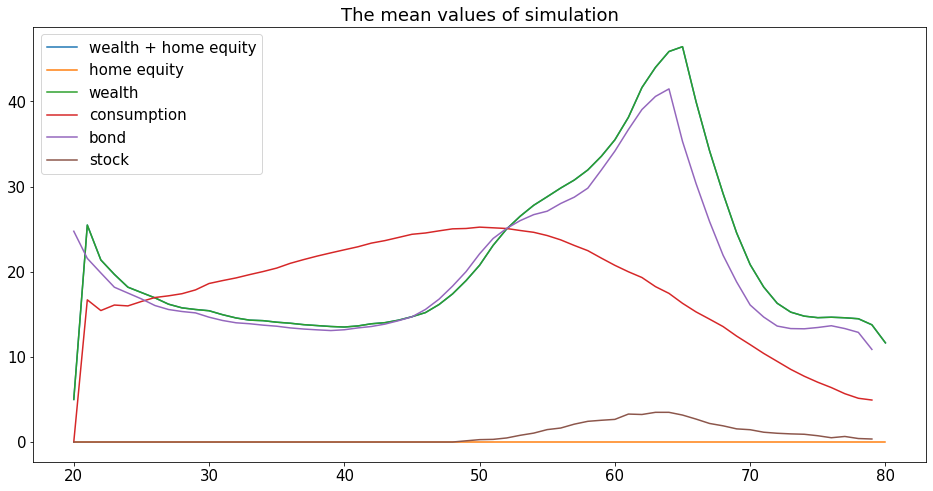

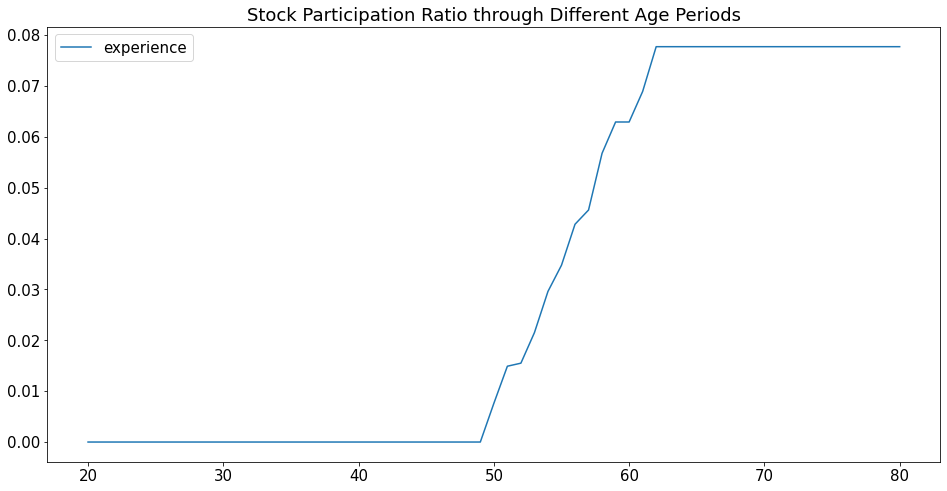

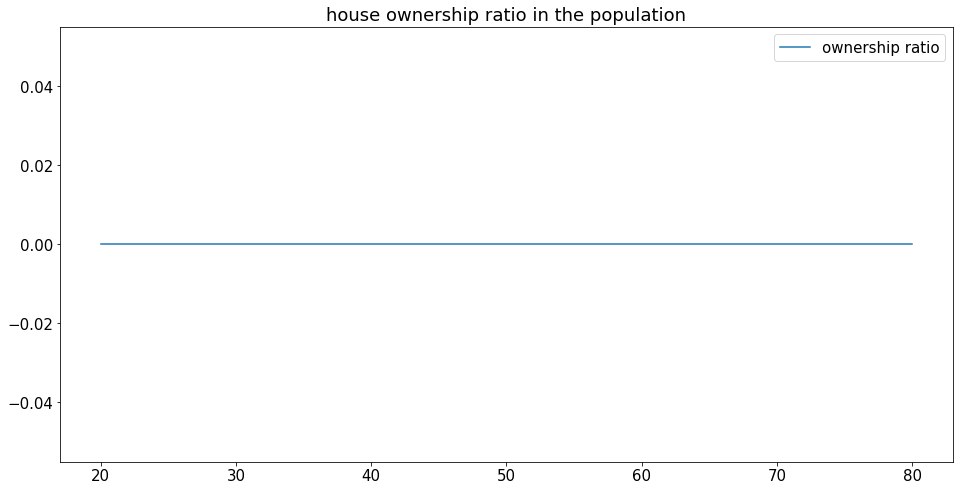

In [4]:
plt.figure(1)
plt.title("The mean values of simulation")
startAge = 20
# value of states, state has one more value, since the terminal state does not have associated action
plt.plot(range(startAge, T_max + startAge + 1),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(startAge, T_max + startAge + 1),jnp.mean(H*pt*os - ms,axis = 1), label = "home equity")
plt.plot(range(startAge, T_max + startAge + 1),jnp.mean(ws,axis = 1), label = "wealth")
# value of actions 
plt.plot(range(startAge, T_max + startAge),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(startAge, T_max + startAge),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(startAge, T_max + startAge),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()

plt.figure(2)
plt.title("Stock Participation Ratio through Different Age Periods")
plt.plot(range(20, T_max + 21),jnp.mean(zs,axis = 1), label = "experience")
plt.legend()

plt.figure(3)
plt.title("house ownership ratio in the population")
plt.plot(range(startAge, T_max + startAge + 1),(os).mean(axis = 1), label = "ownership ratio")
plt.legend()

In [5]:
# agent buying time collection
agentTime = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 1))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)

# agent hold time collection
agentHold = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 0))[0]:
            agentHold.append([t, agentNum])
agentHold = jnp.array(agentHold)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

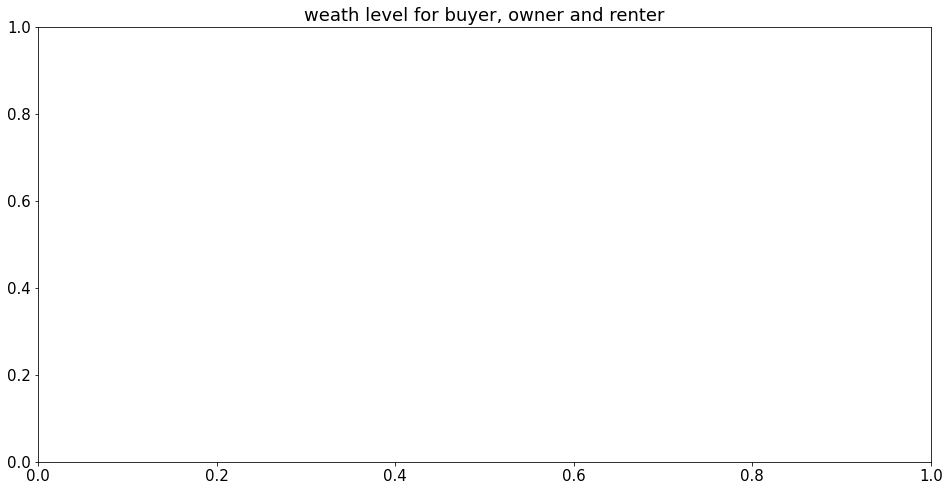

In [6]:
plt.figure(4)
plt.title("weath level for buyer, owner and renter")
www = (os*(ws+H*pt - ms)).sum(axis = 1)/(os).sum(axis = 1)
for age in range(30):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    hp = plt.scatter(age, www[age], color = "green")
    rp = plt.scatter(age, ws[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp,hp,rp), ("FirstTimeBuyer", "HomeOwner", "Renter"))

plt.figure(5)
plt.title("employement status for buyer and renter")
for age in range(31):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    bp = plt.scatter(age, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    rp = plt.scatter(age, es[renter[:,0], renter[:,1]].mean(),color =  "r")
plt.legend((bp, rp), ("FirstTimeBuyer", "Renter"))

In [ ]:
# agent participate time collection
agentTimep = []
for t in range(30):
    if ((zs[t,:] == 0) & (zs[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((zs[t,:] == 0) & (zs[t+1,:] == 1))[0]:
            agentTimep.append([t, agentNum])
agentTimep = jnp.array(agentTimep)

# agent nonparticipate time collection
agentHoldp = []
for t in range(30):
    if ((zs[t,:] == 0) & (zs[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((zs[t,:] == 0) & (zs[t+1,:] == 0))[0]:
            agentHoldp.append([t, agentNum])
agentHoldp = jnp.array(agentHoldp)

In [ ]:
plt.figure(6)
plt.title("weath level for FirstTimeTrader, ExperiencedTrader and Nonparticipant")
www = (zs*(ws+H*pt - ms)).sum(axis = 1)/(zs).sum(axis = 1)
for age in range(30):
    trader = agentTimep[agentTimep[:,0] == age]
    noneTrader = agentHoldp[agentHoldp[:,0] == age]
    tp = plt.scatter(age, ws[trader[:,0], trader[:,1]].mean(),color =  "b")
    ep = plt.scatter(age, www[age], color = "green")
    ip = plt.scatter(age, ws[noneTrader[:,0], noneTrader[:,1]].mean(),color =  "r")
plt.legend((tp,ep,ip), ("FirstTimeTrader", "ExperiencedTrader", "Nonparticipant"))

plt.figure(7)
plt.title("employement status for FirstTimeTrader and Nonparticipant")
for age in range(30):
    trader = agentTimep[agentTimep[:,0] == age]
    noneTrader = agentHoldp[agentHoldp[:,0] == age]
    tp = plt.scatter(age, es[trader[:,0], trader[:,1]].mean(),color =  "b")
    ip = plt.scatter(age, es[noneTrader[:,0], noneTrader[:,1]].mean(),color =  "r")
plt.legend((tp,ip), ("FirstTimeTrader", "Nonparticipant"))

In [ ]:
plt.figure(8)
# At every age
plt.title("Stock Investment Percentage as StockInvestmentAmount/(StockInvestmentAmount + BondInvestmentAmount)")
plt.plot((os[:T_max,:]*ks/(ks+bs)).sum(axis = 1)/os[:T_max,:].sum(axis = 1), label = "owner")
plt.plot(((1-os[:T_max,:])*ks/(ks+bs)).sum(axis = 1)/(1-os)[:T_max,:].sum(axis = 1), label = "renter")
plt.legend()

In [ ]:
plt.figure(9)
# At every age
plt.title("Stock Investment Percentage")
plt.plot(range(startAge, startAge+T_max), (ks/(ks+bs)).mean(axis = 1), label = "ks/(ks+bs)")
plt.legend()

In [ ]:
# # agent number, x = [w,n,m,s,e,o]
# agentNum = 35
# plt.plot(range(20, T_max + 21),(ws + os*(H*pt - ms))[:,agentNum], label = "wealth + home equity")
# plt.plot(range(20, T_max + 21),ms[:,agentNum], label = "mortgage")
# plt.plot(range(20, T_max + 20),cs[:,agentNum], label = "consumption")
# plt.plot(range(20, T_max + 20),bs[:,agentNum], label = "bond")
# plt.plot(range(20, T_max + 20),ks[:,agentNum], label = "stock")
# plt.plot(range(20, T_max + 21),os[:,agentNum]*100, label = "ownership", color = "k")
# plt.legend()

In [ ]:
ws.mean(axis = 1)